In [1]:
# libraries

import pandas as pd # data frames
import numpy as np # numerical calculations
import matplotlib.pyplot as plt # seaborn is built off of matplotlib
from sklearn import preprocessing # used for encoding categorical fields 
from sklearn.feature_selection import SelectKBest, chi2 # used for feature selection
from sklearn.preprocessing import MinMaxScaler # used for scaling features
from statsmodels.stats.outliers_influence import variance_inflation_factor # for multicollinearity testing
from sklearn.model_selection import train_test_split # split data into train and test
from sklearn.linear_model import LogisticRegression # to build model
from sklearn.metrics import classification_report # to review model performance 

In [2]:
# get modified data containing imputted age

modified_data_00_df = pd.read_csv('modified_data_df.csv') # read from user directory

# save copy to be modified as new variable
modified_data_01_df = modified_data_00_df

modified_data_01_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age2
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0


In [3]:
# data exploration 

modified_data_01_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Age2         891 non-null    float64
dtypes: float64(3), int64(5), object(5)
memory usage: 90.6+ KB


In [4]:
# function to convert title to category

def title_category(col_series):
    
    if col_series == 'Dr':
        return 'Doctor'
    elif col_series in ['Lady','Sir']:
        return 'Peerage'
    elif col_series in ['the Countess','Don','Jonkheer']:
        return 'Nobility'
    elif col_series == 'Rev':
        return 'Religious'
    elif col_series in ['Capt','Col','Major']:
        return 'Military'
    else:
        return 'Untitled'

In [5]:
#encode data 

# parse titles from name and add Military, Medical, Religious, Peerage and Nobility fields with dummy encoding
modified_data_01_df['TitleName'] = modified_data_00_df['Name'].apply( lambda x: x.split(', ')[1].split('.')[0])
modified_data_01_df['TitleCategory'] = modified_data_01_df['TitleName'].apply(title_category)
title_cat_df = pd.get_dummies(modified_data_01_df['TitleCategory'],drop_first=True)
modified_data_01_df = pd.concat([modified_data_01_df,title_cat_df],axis=1)
    
# encode sex field
sex_cat_df = pd.get_dummies(modified_data_00_df['Sex'],drop_first=True)
modified_data_01_df = pd.concat([modified_data_01_df,sex_cat_df],axis=1)

# encode embarked field
embrk_cat_df = pd.get_dummies(modified_data_00_df['Embarked'],drop_first=True)
modified_data_01_df = pd.concat([modified_data_01_df,embrk_cat_df],axis=1)

In [6]:
# drop fields not required, drop rows of null embarked then rename

modified_data_01_df.drop(['Name','Sex','Age','Ticket','Cabin','TitleName','TitleCategory'],axis=1,inplace=True)
modified_data_01_df.dropna(inplace=True)
modified_data_01_df.drop(['Embarked'],axis=1,inplace=True)
modified_data_01_df.rename(columns={'male': 'Male', 'Age2': 'Age', 'Q':'EmbrkQ', 'S':'EmbrkS'},inplace=True)

In [7]:
modified_data_01_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   SibSp        889 non-null    int64  
 4   Parch        889 non-null    int64  
 5   Fare         889 non-null    float64
 6   Age          889 non-null    float64
 7   Military     889 non-null    uint8  
 8   Nobility     889 non-null    uint8  
 9   Peerage      889 non-null    uint8  
 10  Religious    889 non-null    uint8  
 11  Untitled     889 non-null    uint8  
 12  Male         889 non-null    uint8  
 13  EmbrkQ       889 non-null    uint8  
 14  EmbrkS       889 non-null    uint8  
dtypes: float64(2), int64(5), uint8(8)
memory usage: 62.5 KB


In [8]:
# observe that features have different scales 
modified_data_01_df.head(5)

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Age,Military,Nobility,Peerage,Religious,Untitled,Male,EmbrkQ,EmbrkS
0,1,0,3,1,0,7.2500,22.0,0,0,0,0,1,1,0,1
1,2,1,1,1,0,71.2833,38.0,0,0,0,0,1,0,0,0
2,3,1,3,0,0,7.9250,26.0,0,0,0,0,1,0,0,1
3,4,1,1,1,0,53.1000,35.0,0,0,0,0,1,0,0,1
4,5,0,3,0,0,8.0500,35.0,0,0,0,0,1,1,0,1


In [9]:
# create a scaled dataset
# necessary when for reviewing feature importance based on coefficients
scaler = MinMaxScaler()
scaler.fit(modified_data_01_df)
modified_data_02_df = pd.DataFrame( scaler.transform(modified_data_01_df) )

# use a dict comprehension to turn the tuples into a dict
col_rename_dict = {i:j for i,j in zip( list(modified_data_02_df.columns.values), 
                                       list(modified_data_01_df.columns.values))}
modified_data_02_df.rename(columns=col_rename_dict, inplace=True)

modified_data_02_df.head(5)

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Age,Military,Nobility,Peerage,Religious,Untitled,Male,EmbrkQ,EmbrkS
0,0.000000,0.0,1.0,0.125,0.0,0.014151,0.271174,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,0.001124,1.0,0.0,0.125,0.0,0.139136,0.472229,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.002247,1.0,1.0,0.000,0.0,0.015469,0.321438,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.003371,1.0,0.0,0.125,0.0,0.103644,0.434531,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.004494,0.0,1.0,0.000,0.0,0.015713,0.434531,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [10]:
# function returns "yes" or "no" to determine whether target variable is binary, i.e. 0 or 1 values only
# binary assumption check

def target_binary(dataframe, target):
    
    if pd.unique(dataframe[target])[0] == 0 and pd.unique(dataframe[target])[1] == 1:
        return "Yes"
    else:
        return "No"
    
target_binary(modified_data_02_df, 'Survived')  

'Yes'

In [11]:
# binary and balanced target assumption check

balanced_test_df = modified_data_02_df.groupby('Survived').count().reset_index()[ ['Survived','PassengerId'] ]
balanced_test_df['Passenger%'] = np.round((balanced_test_df['PassengerId'] / 
                                           balanced_test_df['PassengerId'].sum()) * 100,1) 
balanced_test_df

,Survived,PassengerId,Passenger%
0,0.0,549,61.8
1,1.0,340,38.2


In [14]:
# function returns dataframe of feature pairwise correlation in descending |R2| 
# multi-collinearity assumption check 

def corr_pair(dataframe, target):
    
    # initialization
    ex_target_df = dataframe.drop([target], axis=1)
    features = ex_target_df.columns.to_list()
    multi_coll_df = pd.DataFrame(columns='index feature R2'.split())

    # pair wise correlation
    for feature in features:
        df_corr = pd.DataFrame( ex_target_df[ ex_target_df.columns[:] ].corr()[feature] ).reset_index()
        df_corr.rename(columns={feature:'R2'}, inplace=True) 
        df_corr.insert(1, 'feature', feature) 
        multi_coll_df = pd.concat([df_corr, multi_coll_df], ignore_index=True)
    multi_coll_df['ABS'] = np.abs(multi_coll_df['R2']) 

    multi_coll_df.drop(multi_coll_df[multi_coll_df['ABS'] == 1].index, inplace=True) # drop self-correlated features
    multi_coll_df.sort_values(by='ABS', ascending=False, inplace=True)
    multi_coll_df.drop(multi_coll_df[multi_coll_df['ABS'] == 1].index, inplace=True)
    multi_coll_df.drop(multi_coll_df.iloc[1::2, :].index, inplace=True) # drop every second result, i.e. duplicates

    multi_coll_df.insert(0, 'features', multi_coll_df['index'] + '_' + multi_coll_df['feature'])
    multi_coll_df.drop(['index', 'feature', 'ABS'], axis=1, inplace=True)
    multi_coll_df.reset_index(drop=True, inplace=True)

    return multi_coll_df
    
corr_pair(modified_data_02_df, 'Survived').round(4)

,features,R2
0,Pclass_Fare,-0.5482
1,Religious_Untitled,-0.5058
2,EmbrkQ_EmbrkS,-0.4993
3,Military_Untitled,-0.4615
4,Parch_SibSp,0.4145
...,...,...
86,Peerage_Military,-0.0036
87,Nobility_Peerage,-0.0028
88,Nobility_Male,0.0021
89,Parch_PassengerId,-0.0017


In [15]:
# function returns dataframe of multicollinearity values for assumption check 

def multicoll(dataframe, target):

    x = dataframe.drop(target, axis=1)

    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = x.columns

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(len(x.columns))]

    vif_data.sort_values(by='VIF', ascending=False, inplace=True)
    vif_data.reset_index(drop=True, inplace=True)

    return vif_data

multicoll(modified_data_02_df, 'Survived').round(2)

,feature,VIF
0,Untitled,21.51
1,Age,7.00
2,Pclass,6.48
3,EmbrkS,5.28
4,PassengerId,3.94
5,Male,3.20
6,Fare,2.30
7,Parch,1.64
8,EmbrkQ,1.62
9,SibSp,1.58


In [16]:
# function returns required population size using "one in ten" rule as default 
# large dataset size assumption check 

def dataset_size_test(dataframe, target, cases=10):
    
    total_outcomes_count = len(dataframe)
    
    # count all feature columns by target and use the first column to obtain least likely outcome
    least_likely_outcome_count = dataframe.groupby(target).count().reset_index().iloc[:, 1].min()
    
    # least likely outcome as a percentage
    least_likely_outcome = least_likely_outcome_count / total_outcomes_count
    
    # count of features 
    features_count = np.count_nonzero(dataframe.columns != target)

    return (cases / least_likely_outcome) * features_count
    
required_size = dataset_size_test(modified_data_02_df, 'Survived')
np.round(required_size,0)

366.0

In [17]:
# function to determine average chi-squared for feature selection
# supplementary for feature selection

def chi_sqr(dataframe, target, trials):
    
    chi_sqr_dfs_list = []
    
     # ith trial used as random state 
    for i in range(1,trials+1): 
        
        x_train, x_test, y_train, y_test = train_test_split(dataframe.drop(target,axis=1), 
                                                            dataframe[target], test_size=0.30, 
                                                            random_state=i)

        # features list
        ftr_list = dataframe.drop(target,axis=1).columns.values.tolist()
        
        # fit chi-squared
        fs = SelectKBest(score_func=chi2,k='all')
        fs.fit(x_train, y_train)

        # feature scores to list of tuples then dataframe
        chi_sqr_list = []
        for i in range(len(fs.scores_)):
            chi_sqr_list.append( (ftr_list[i], fs.scores_[i]) )
            chi_sqr_df = pd.DataFrame(chi_sqr_list)  
        
        # add chisqr dataframes to list
        chi_sqr_dfs_list.append(chi_sqr_df)
        
    # convert list of dataframes to a single frame and calculate average
    chi_sqr_all_df = pd.concat(chi_sqr_dfs_list, ignore_index=True)
    chi_sqr_all_df.rename( {0:'Feature',1:'ChiSqr' }, axis=1, inplace=True)
    
    return chi_sqr_all_df.groupby('Feature').mean().reset_index()

chi_sqr_results_df = chi_sqr(modified_data_02_df, 'Survived', 10)
chi_sqr_results_df.sort_values('ChiSqr',ascending=False).round(2)

,Feature,ChiSqr
4,Male,62.96
9,Pclass,19.31
3,Fare,6.16
2,EmbrkS,4.12
10,Peerage,2.91
11,Religious,2.65
7,Parch,1.37
6,Nobility,0.77
5,Military,0.30
12,SibSp,0.25


In [21]:
# function to assess model performance

# drop feature(s) with VIF >= 10 per ARA text p206 from dataframe
def log_mod_assess(dataframe, target, trials):
    
    log_models_list = []
    
    # ith trial used as random state 
    for i in range(1,trials+1): 
        
        # split into train and test datasets
        x_train, x_test, y_train, y_test = train_test_split(dataframe.drop(target,axis=1), 
                                                            dataframe[target], test_size=0.30, 
                                                            random_state=i)
        # make predictions
        logmodel = LogisticRegression(max_iter=1000) 
        logmodel.fit(x_train,y_train)
        predictions = logmodel.predict(x_test)
        
        # create classification report, reformat column wise for each trial and append to a list
        report = classification_report(y_test, predictions, output_dict=True)
        class_rep_df = pd.DataFrame(report).reset_index().pivot(columns='index')
        class_rep_df.columns = class_rep_df.columns.to_series().str.join('_') # flatten and concatenate multilevel column
        class_rep_df.insert(0, 'GrpBy', '-')
        class_rep_df = class_rep_df.groupby('GrpBy').sum().reset_index()
        class_rep_df.drop('GrpBy',axis=1,inplace=True)
        class_rep_df.drop(class_rep_df.iloc[:, 9:],axis=1,inplace=True)
        class_rep_df.rename(columns={'accuracy_f1-score':'accuracy'}, inplace=True)
        
        # generate pearson residuals, count greater than 2, count greater than 5 and attach as new columns
        predict_prob = logmodel.predict_proba(x_test)[0:,1]
        raw_residuals = y_test - predict_prob
        pearson_residuals = raw_residuals / np.sqrt( predict_prob * (1-predict_prob) )
        pearson_df = pearson_residuals.abs()        
        class_rep_df.insert(9, 'StdDist>=2&<3', pearson_df[ (pearson_df >= 2) & (pearson_df < 3) ].count())
        class_rep_df.insert(10, 'StdDist>=3', pearson_df[ pearson_df >= 3 ].count())
        class_rep_df.insert(11, 'Trials', trials)
        class_rep_df.insert(12, 'RandomState', i)
        
        
        # attach all data drames to a list 
        log_models_list.append(class_rep_df)
        
    # convert list of dataframes to a single frame
    log_models_all_df = pd.concat(log_models_list, ignore_index=True)
    
    # change order of columns
    log_models_all_df = log_models_all_df[['0.0_precision', '0.0_recall', '0.0_f1-score', '0.0_support',  
                                            '1.0_precision', '1.0_recall', '1.0_f1-score', '1.0_support', 
                                           'accuracy', 'StdDist>=2&<3', 'StdDist>=3','Trials', 'RandomState']] 
    # rename columns
    log_models_all_df.rename(columns={ '0.0_precision':'0_precision', '0.0_recall':'0_recall', 
                                       '0.0_f1-score':'0_f1-score', '0.0_support':'0_support',
                                       '1.0_precision':'1_precision', '1.0_recall':'1_recall', 
                                       '1.0_f1-score':'1_f1-score', '1.0_support':'1_support',}, inplace = True)

    return log_models_all_df.round(2)

In [19]:
# display summarized results
results_df = log_mod_assess(modified_data_02_df.drop('Untitled',axis=1), 'Survived', 25)
results_avg_df = pd.DataFrame(results_df.iloc[ 0:, results_df.columns != 'RandomState'  ].mean()).transpose()
results_avg_df.round(2)

,0_precision,0_recall,0_f1-score,0_support,1_precision,1_recall,1_f1-score,1_support,accuracy,StdDist>=2&<3,StdDist>=3,Trials
0,0.82,0.87,0.84,165.0,0.76,0.7,0.73,102.0,0.8,10.96,4.88,25.0


In [23]:
# display all results
results_df = log_mod_assess(modified_data_02_df.drop('Untitled',axis=1), 'Survived', 25)
results_df

,0_precision,0_recall,0_f1-score,0_support,1_precision,1_recall,1_f1-score,1_support,accuracy,StdDist>=2&<3,StdDist>=3,Trials,RandomState
0,0.87,0.85,0.86,166.0,0.76,0.78,0.77,101.0,0.82,6,0,25,1
1,0.86,0.89,0.88,170.0,0.80,0.74,0.77,97.0,0.84,10,0,25,2
2,0.76,0.91,0.83,158.0,0.82,0.58,0.68,109.0,0.78,7,18,25,3
3,0.81,0.85,0.83,164.0,0.74,0.68,0.71,103.0,0.79,11,7,25,4
4,0.86,0.91,0.88,172.0,0.82,0.73,0.77,95.0,0.85,14,3,25,5
5,0.82,0.87,0.84,162.0,0.78,0.70,0.73,105.0,0.80,8,4,25,6
6,0.80,0.84,0.82,160.0,0.74,0.68,0.71,107.0,0.78,11,4,25,7
7,0.86,0.85,0.85,166.0,0.76,0.77,0.76,101.0,0.82,11,4,25,8
8,0.81,0.86,0.83,161.0,0.77,0.69,0.73,106.0,0.79,11,1,25,9
9,0.82,0.87,0.84,169.0,0.75,0.66,0.70,98.0,0.79,12,7,25,10


In [20]:
# display top, middle, worst results, sort by StdDist>=3 ascending, then Accuracy descending  
results_df = log_mod_assess(modified_data_02_df.drop('Untitled',axis=1), 'Survived', 25)
results_df.sort_values(['StdDist>=3','accuracy'], ascending=[True, False], inplace=True)
results_df = results_df.reset_index(drop=True)
results_df
results_df.iloc[ [0, 12, 24], results_df.columns != 'Trials']

,0_precision,0_recall,0_f1-score,0_support,1_precision,1_recall,1_f1-score,1_support,accuracy,StdDist>=2&<3,StdDist>=3,RandomState
0,0.86,0.89,0.88,170.0,0.80,0.74,0.77,97.0,0.84,10,0,2
12,0.82,0.87,0.84,162.0,0.78,0.70,0.73,105.0,0.80,8,4,6
24,0.76,0.91,0.83,158.0,0.82,0.58,0.68,109.0,0.78,7,18,3


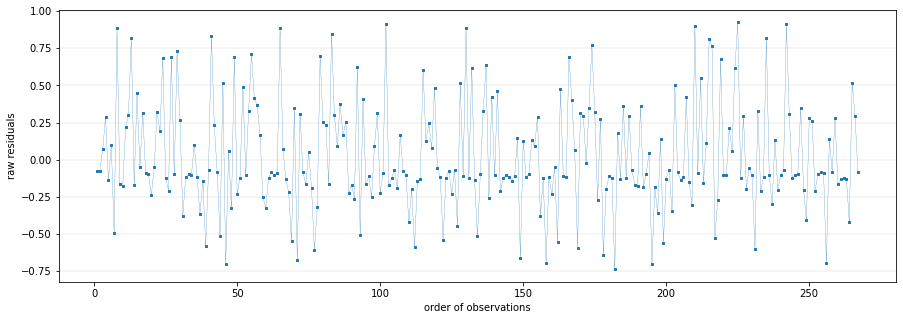

In [28]:
# raw residuals for independence assumption check
# use random state for median model for n trials and drop same feature(s) and target as in previous function  

med_model_rand_state = 6

# run model
x_train, x_test, y_train, y_test = train_test_split(modified_data_02_df.drop(['Survived','Untitled'],axis=1), 
                                                    modified_data_02_df['Survived'], test_size=0.30, 
                                                    random_state=med_model_rand_state)
logmodel = LogisticRegression(max_iter=1000) 
logmodel.fit(x_train,y_train)
predictions = logmodel.predict(x_test)

# calculate and display raw residuals
predict_prob = logmodel.predict_proba(x_test)[0:,1]
raw_residuals = y_test - predict_prob

fig, axes = plt.subplots(figsize=(15,5))
axes.plot( list(range(1,len(predictions)+1)), raw_residuals, lw=0.25, marker='s', markersize=2.5)
plt.grid(axis = 'y', lw=0.25)
plt.xlabel('order of observations')
plt.ylabel('raw residuals')
plt.show()

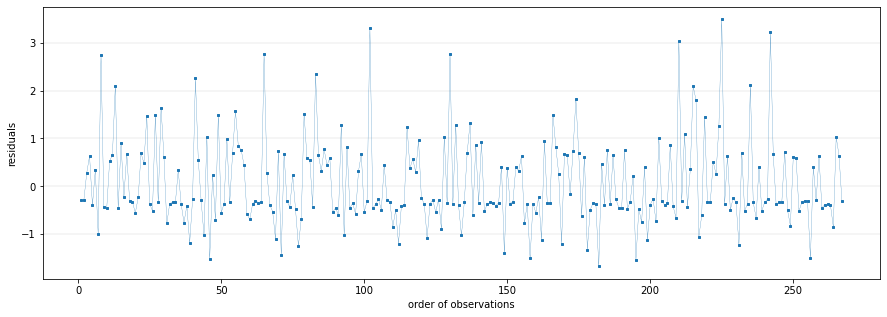

In [24]:
# pearson residuals for outliers 
# use random state for median model for n trials and drop same feature(s) and target as in previous function  

# calculate and display raw residuals
predict_prob = logmodel.predict_proba(x_test)[0:,1]
raw_residuals = y_test - predict_prob
pearson_residuals = raw_residuals / np.sqrt( predict_prob * (1-predict_prob) )

fig, axes = plt.subplots(figsize=(15,5))
axes.plot( list(range(1,len(predictions)+1)), pearson_residuals, lw=0.25, marker='s', markersize=2.5)
plt.grid(axis = 'y', lw=0.25)
plt.xlabel('order of observations')
plt.ylabel('residuals')
plt.show()


In [25]:
# middle model intercept and coefficients

print(  '\033[1m' + '    Intercept      ' + str( np.round(np.squeeze(logmodel.intercept_),4)) + '\033[1m' )

coeff_df = pd.DataFrame(x_test.columns)
coeff_df[1] = pd.DataFrame(logmodel.coef_).transpose()
coeff_df[2] = coeff_df[1].abs()
coeff_df.rename( {0:'Features',1:'CoeffLogOdds',2:'CoeffAbs' }, axis=1, inplace=True )
coeff_df.sort_values('CoeffAbs',ascending=False, inplace=True)
coeff_df = coeff_df.reset_index(drop=True)
coeff_df.insert(3, 'CoeffOdds', np.exp(coeff_df['CoeffLogOdds']))
coeff_df.insert(4, 'CoeffOddsSurvived', 
                np.where( np.exp(coeff_df['CoeffLogOdds']) >= 1, np.exp(coeff_df['CoeffLogOdds']), np.nan))
coeff_df.insert(5, 'CoeffOddsNotSurvived', 
                np.where( np.exp(coeff_df['CoeffLogOdds']) < 1, 1 / np.exp(coeff_df['CoeffLogOdds']), np.nan))
# coeff_df.insert(6, 'CoeffProbSurvived', 
#                 np.where( np.exp(coeff_df['CoeffLogOdds']) >= 1, 
#                           np.exp(coeff_df['CoeffLogOdds']) / (1+np.exp(coeff_df['CoeffLogOdds'])), np.nan))
# coeff_df.insert(7, 'CoeffProbNotSurvived', 
#                 np.where( np.exp(coeff_df['CoeffLogOdds']) < 1, 
#                           (1 / np.exp(coeff_df['CoeffLogOdds'])) / (1+(1 / np.exp(coeff_df['CoeffLogOdds']))), np.nan))
coeff_df[ ['Features', 'CoeffLogOdds', 'CoeffOdds', 'CoeffOddsSurvived', 'CoeffOddsNotSurvived'] ].round(2)

    Intercept      2.9936


,Features,CoeffLogOdds,CoeffOdds,CoeffOddsSurvived,CoeffOddsNotSurvived
0,Male,-2.36,0.09,NaN,10.59
1,Pclass,-1.74,0.17,NaN,5.72
2,Age,-1.65,0.19,NaN,5.20
3,SibSp,-1.44,0.24,NaN,4.20
4,EmbrkS,-0.66,0.52,NaN,1.93
5,Fare,0.54,1.72,1.72,NaN
6,Peerage,0.50,1.65,1.65,NaN
7,Religious,-0.48,0.62,NaN,1.62
8,PassengerId,0.37,1.45,1.45,NaN
9,Parch,-0.30,0.74,NaN,1.35


In [27]:
# middle model view predictions

predictions = logmodel.predict(x_test[0:8])

print('logmodel.predict(x_test[0:8])\n')
print(' ')
for _ in predictions:
    print(_)

logmodel.predict(x_test[0:8])

 
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0


In [85]:
# middle model view probabilities

# logmodel.predict_proba(x_train)
print('logmodel.predict_proba(x_test)[0:8]\n')
logmodel.predict_proba(x_test)[0:8].round(4)

logmodel.predict_proba(x_test)[0:8]



array([[0.9238, 0.0762],
       [0.9225, 0.0775],
       [0.0711, 0.9289],
       [0.2892, 0.7108],
       [0.8637, 0.1363],
       [0.1   , 0.9   ],
       [0.505 , 0.495 ],
       [0.8834, 0.1166]])

In [84]:
# middle model logistic function confirm probabilities

features_test_array = np.squeeze(np.array(x_test.head(8)))
coeff_test_array = np.squeeze(logmodel.coef_)

prob_array_test_01 = ( np.exp(np.dot(features_test_array, coeff_test_array) + logmodel.intercept_ )  /
                       (1 + np.exp(np.dot(features_test_array, coeff_test_array) + logmodel.intercept_ )))

print('= (np.exp(np.dot(features_test_array, coeff_test_array) +  logmodel.intercept_)')
print('/ (1 + np.exp(np.dot(features_test_array, coeff_test_array) +  logmodel.intercept_))\n')
for _ in prob_array_test_01.tolist():
    print(round(_,4))


= (np.exp(np.dot(features_test_array, coeff_test_array) +  logmodel.intercept_)
/ (1 + np.exp(np.dot(features_test_array, coeff_test_array) +  logmodel.intercept_))

0.0762
0.0775
0.9289
0.7108
0.1363
0.9
0.495
0.1166


logit_resp_var = np.log( logmodel.predict_proba(x_test)[0:,1] / (1- logmodel.predict_proba(x_test)[0:,1]) )
expl_var       = np.dot(features_test_array, coeff_test_array) +  logmodel.intercept_


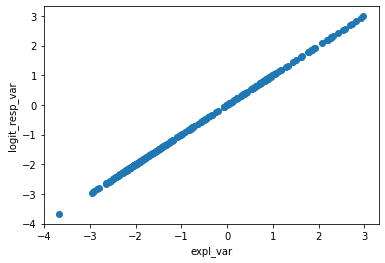

In [33]:
# middle model linear relationship between each explanatory variable and the logit of the response variable 

features_test_array = np.squeeze(np.array(x_test))
coeff_test_array = np.squeeze(logmodel.coef_)
expl_var_test = np.dot(features_test_array, coeff_test_array) +  logmodel.intercept_
# print( expl_var_test[0:5] )

logit_resp_var_test = np.log( logmodel.predict_proba(x_test)[0:,1] / (1- logmodel.predict_proba(x_test)[0:,1]) )
# print( logit_resp_var_test[0:5] )

print('logit_resp_var = np.log( logmodel.predict_proba(x_test)[0:,1] / (1- logmodel.predict_proba(x_test)[0:,1]) )')
print('expl_var       = np.dot(features_test_array, coeff_test_array) +  logmodel.intercept_')
plt.scatter( np.squeeze(expl_var_test), np.squeeze(logit_resp_var_test) )
plt.xlabel('expl_var')
plt.ylabel('logit_resp_var')
plt.show()


In [150]:
#  middle model confirm accuracy

observations = np.array(y_test)
predictions
(np.sum(observations == predictions) / len(observations)).round(2) 

0.8